In [1]:
from eda_imports import *

In [2]:
# first 3 lines are like below, probably from exporting Excel kind of tool
# YEAR 2016,,,,,,,,
# "Remuneration and Expenses for Employees Earning over $75,000",,,,,,,,
# ,,,,,,,,
dfs = []
for i in glob.glob('./data/*.csv'):
    print('loading {0}'.format(i))
    year = int(re.search(r'\d{4}', i).group())
    if '2014' in i:
        n_skip = 2 # outlier
    else:
        n_skip = 3
    df = pd.read_csv(i, skiprows=n_skip, encoding="ISO-8859-1")
    df.columns = [_.strip() for _ in df.columns.tolist()]
    df = df[['Name', 'Department', 'Title', 'Remuneration', 'Expenses']]
    df['Year'] = year
    # rename Total row
    df = df.query('Name != "Total"').query('Name != "  Total"')
    dfs.append(df)
ndf = pd.concat(dfs)

loading ./data/2008StaffRemunerationOver75KWithExpenses.csv
loading ./data/2009StaffRemunerationOver75KWithExpenses.csv
loading ./data/2010StaffRemunerationOver75KWithExpenses.csv
loading ./data/2011StaffRemunerationOver75KWithExpenses.csv
loading ./data/2012StaffRemunerationOver75KWithExpenses.csv
loading ./data/2013StaffRemunerationOver75KWithExpenses.csv
loading ./data/2014StaffRemunerationOver75KWithExpenses.csv
loading ./data/2015StaffRemunerationOver75KWithExpenses.csv
loading ./data/2016StaffRemunerationOver75KWithExpenses.csv


In [3]:
ndf.shape

(16976, 6)

In [4]:
ndf.head()

,Name,Department,Title,Remuneration,Expenses,Year
0,"Abel, K J",Fire and Rescue Services,Fire Captain,"92,210.44",0.00,2008
1,"Abrams, W S",Fire and Rescue Services,Firefighter,"75,109.89",0.00,2008
2,"Achtymichuk, L M",Fire and Rescue Services,Firefighter,"81,481.68",0.00,2008
3,"Ackerman, R W",Community Services,Director Civic Theatres,"133,855.38","1,941.77",2008
4,"Breckner, J",Business Planning & Services,Associate Director Real Estate,"114,202.66","1,233.94",2008


In [5]:
def convert_remuneration(s):
    if isinstance(s, str):
        return float(s.replace(',', '').replace('$', ''))
    else:
        return s

In [6]:
ndf['Remuneration'] = ndf.Remuneration.apply(convert_remuneration)
ndf['Expenses'] = ndf.Expenses.apply(convert_remuneration)

In [7]:
ndf[['Remuneration', 'Expenses']].describe()

,Remuneration,Expenses
count,16949.000000,16949.000000
mean,97150.720589,334.690116
std,23709.454735,1005.533321
min,75000.100000,0.000000
25%,81620.100000,0.000000
50%,90431.350000,0.000000
75%,105495.310000,96.050000
max,568447.810000,20302.910000


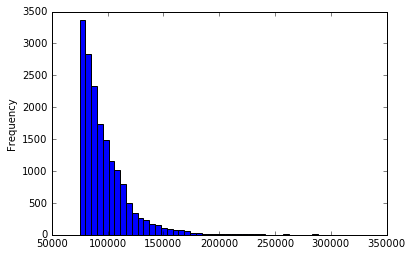

In [8]:
ndf.Remuneration.dropna().plot.hist(bins=np.linspace(75000, 330000, 50))

This is much smoother than the single-year version with more data

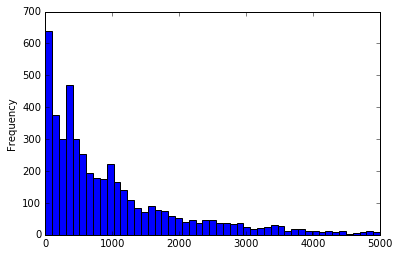

In [9]:
ndf.query('Expenses > 0').Expenses.dropna().plot.hist(bins=np.linspace(0, 5000, 50))

### Top paid employees

In [10]:
ndf.sort_values('Remuneration', ascending=False).head(20).reset_index(drop=True)

,Name,Department,Title,Remuneration,Expenses,Year
0,"Rogers, J",Office of the City Manager,City Manager,568447.81,2546.00,2008
1,"Lo, E",Financial Services,General Manager - Corporate Services,398365.46,3989.25,2008
2,"Ballem, P J*",Office of the City Manager,City Manager,366009.05,11475.22,2012
3,"McKearney, J R*",Fire and Rescue Services,Fire Chief - Fire & Rescue Services,347761.99,10654.37,2013
4,"Ballem, P J",Office of the City Manager,City Manager,343767.40,475.45,2015
5,"Ballem, P J",Office of the City Manager,City Manager,339219.43,5513.23,2013
6,"Ballem, P J",Office of the City Manager,City Manager,334617.31,2033.19,2014
7,"Ballem, P J",Office of the City Manager,City Manager,334002.04,2930.73,2011
8,"Johnston, S",Office of the City Manager,City Manager,328583.08,2953.99,2016
9,"Ballem, P J",Office of the City Manager,City Manager,324109.96,2791.67,2010


In 2008, the City Manager gets over half a million.

# Top paying departments

In [11]:
by_dept = ndf.groupby('Department').apply(lambda g: g.Remuneration.describe()[['count', 'mean', 'std']]).fillna(0)

In [12]:
by_dept = by_dept.sort_values('mean', ascending=False).reset_index()

(-1, 23)

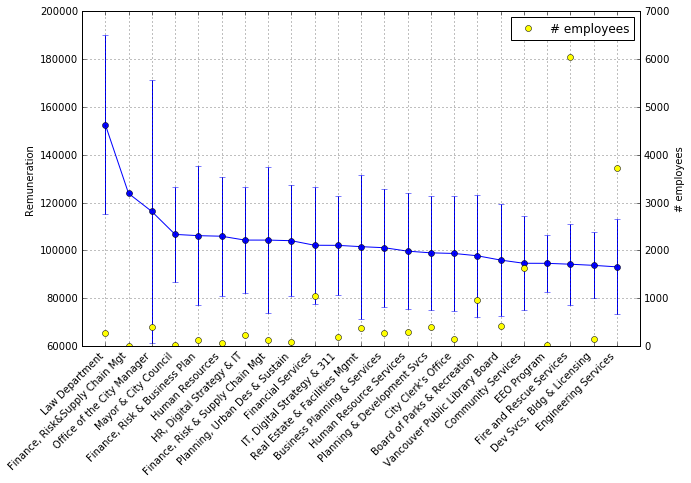

In [13]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
xs = by_dept.index.values
ax.errorbar(xs, y=by_dept['mean'].values, marker='o', yerr=by_dept['std'].values)
ax.set_xticks(xs)
_ = ax.set_xticklabels(by_dept.Department.values, rotation=45, ha='right')
ax.set_ylabel('Remuneration')
ax.grid()

ax2 =ax.twinx()
ax2.plot(xs, by_dept['count'], 'o', color='yellow', label='# employees')
ax2.set_ylabel('# employees')
ax2.legend(numpoints=1)

ax.set_xlim(-1, xs[-1] + 1)

Error bars stand for standard deviation. When the number of empolyess from a department is small, the standard errow may be big.

# Top paying titles

In [14]:
by_title = ndf.groupby('Title').apply(lambda g: g.Remuneration.describe()[['count', 'mean', 'std']]).fillna(0)

In [15]:
by_title = by_title.sort_values('mean', ascending=False).reset_index()

(-1, 1370)

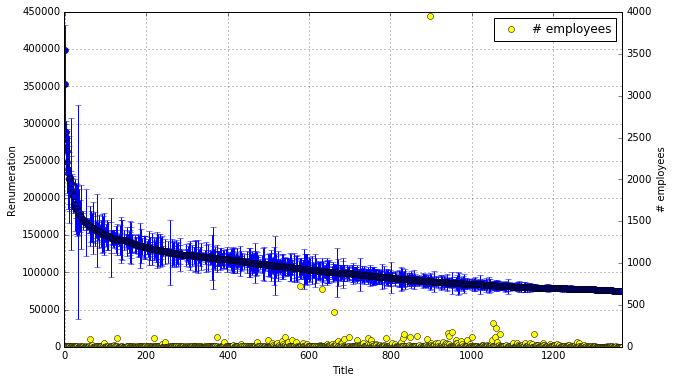

In [16]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
xs = by_title.index.values
ax.errorbar(xs, y=by_title['mean'].values, marker='o', yerr=by_title['std'].values)
# ax.set_xticks(xs)
# _ = ax.set_xticklabels(by_title.Title.values, rotation=45, ha='right')
ax.set_xlabel('Title')
ax.set_ylabel('Renumeration')
ax.grid()

ax2 =ax.twinx()
ax2.plot(xs, by_title['count'], 'o', color='yellow', label='# employees')
ax2.set_ylabel('# employees')
ax2.legend(numpoints=1)

ax.set_xlim(-1, xs[-1] + 1)

So there is a cliff for the first ~20 titles. We'll show them as well the bottom ones.

In [17]:
by_title.head(30)

Remuneration,Title,count,mean,std
0,General Manager - Corporate Services,1.0,398365.460000,0.000000
1,City Manager,10.0,353756.492000,78267.908711
2,Director - Legal Services & City Solicitor,1.0,288924.350000,0.000000
3,Chief Housing Officer,3.0,282210.240000,6284.486274
4,Director Legal Services & City Solicitor,8.0,267891.600000,35896.662425
5,General Manager,3.0,263807.806667,28417.695093
6,General Manager Financial Services,7.0,248969.855714,41704.381531
7,General Manager Business Planning & Srvc,6.0,239446.988333,35211.839924
8,General Manager-Parks & Recreation,7.0,232994.665714,47567.435633
9,General Manager - Engineering Services,12.0,226815.263333,34515.020517


In [18]:
by_title.tail(20)

Remuneration,Title,count,mean,std
1350,Planner II - Park Board,1.0,75579.540000,0.000000
1351,Trades Il - Carpenter,1.0,75542.800000,0.000000
1352,Manager By-Law Admin & Record Services,1.0,75509.960000,0.000000
1353,Learning Support Specialist,1.0,75464.920000,0.000000
1354,Events Coordinator,1.0,75454.340000,0.000000
1355,Engineering Design Assistant,6.0,75425.998333,729.749875
1356,Case Manager I,1.0,75391.430000,0.000000
1357,Tree Pruner I,1.0,75358.280000,0.000000
1358,Maintenance Technician II,3.0,75331.586667,289.261981
1359,Storekeeper II - Fire,1.0,75313.400000,0.000000
